In [1]:
from util import *

Using device: cuda


In [2]:
genres = set()
for game in game_map:
    genres.add(game_map[game])
genres = list(genres)
indices = {}
for i, genre in enumerate(genres):
    indices[genre] = i
print(genres, indices)

['shooter', 'rpg', 'puzzle', 'racing', 'strategy'] {'shooter': 0, 'rpg': 1, 'puzzle': 2, 'racing': 3, 'strategy': 4}


In [3]:
def remap_to_simple(game_map):
    for game in game_map:
        if game_map[game] == 'strategy' or game_map[game] == 'puzzle':
            game_map[game] = 'strategy'
        elif game_map[game] == 'rpg':
            game_map[game] = 'rpg'
        else:
            game_map[game] = 'pure action'
    genres = set()
    for game in game_map:
        genres.add(game_map[game])
    genres = list(genres)
    for i, genre in enumerate(genres):
        indices[genre] = i
    return genres, indices

In [4]:
# genres, indices = remap_to_simple(game_map) # Comment out to use 5 classes or leave in for 3 classes

In [5]:
size = 15
width = 16 * size
height = 9 * size
length = 3

test_data = []
test_labels = []
train_data = []
train_labels = []

In [6]:
print(genres)

['shooter', 'rpg', 'puzzle', 'racing', 'strategy']


In [7]:
train_images = ('train', np.array(os.listdir(os.path.join('input_images', 'train'))))
test_images = ('test', np.array(os.listdir(os.path.join('input_images', 'test'))))

In [8]:
nt = transforms.Compose([ # Only tensor + normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([ # Greatly transform image
    
    # Randomly apply color jitters or random perspectives
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5)
    ], p=0.9),

    # Apply some random flips and rotations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15.0),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [9]:
def generate_sequences(images, length, ratio=1.0, skip=False):
    X, y = [], []
    final_images = []
    sort = sorted(images[1])
    current_game = None
    game_number = None
    queue = []
    for image in sort:
        game_name = image.split(';;')[0]
        genre = game_map[game_name]
        classification = indices[genre]
        if len(image.split(';;')[1].split('_')) == 1:
            continue
        video_number = int(image.split(';;')[1].split('_')[0])
        sequence_number = int(image.split(';;')[1].split('_')[1].split('.')[0])
        if current_game is None or current_game != game_name or game_number != video_number:
            current_game = game_name
            game_number = video_number
            queue = []
        queue.append(nt(Image.open(os.path.join('input_images', images[0], image)).convert('RGB').resize((320, 180))).numpy())
        if len(queue) > length:
            queue.pop(0)
        if len(queue) == length and random.randrange(100) < ratio * 100:
            X.append(queue)
            y.append(classification)
            final_images.append(image)
            if skip:
                queue = []
                current_game = None
                game_number = None
    return X, y, final_images

In [10]:
train_data, train_labels, _ = generate_sequences(train_images, length)
test_data, test_labels, _ = generate_sequences(test_images, length, ratio=0.7)

In [11]:
n_train = len(train_data)
n_test = len(test_data)
n_classes = len(genres)

print(f'Train size: {n_train}, Test Size: {n_test}, with {n_classes} classes')

Train size: 2196, Test Size: 246, with 5 classes


In [12]:
X_train_tensor = torch.tensor(np.array(train_data), device = device).float()
X_test_tensor = torch.tensor(np.array(test_data), device = device).float()
y_train_tensor = torch.tensor(train_labels, device = device)
y_test_tensor = torch.tensor(test_labels, device = device)

y_train_onehot = F.one_hot(y_train_tensor.to(torch.int64), num_classes=n_classes).float()
y_test_onehot = F.one_hot(y_test_tensor.to(torch.int64), num_classes=n_classes).float()

In [13]:
# define the training and testing mechanisms to load in images as datasets
BATCH_SIZE = 32

# first contruct the training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)

# then the testing set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle = False)

In [14]:
class ClassificationRNN(nn.Module):
    def __init__(self):
        super(ClassificationRNN, self).__init__()

        # construct the convolutional layers
        # Output sizes are hyperparameters
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(24, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )

        bidirectional = True
        conv_output_size = 8
        hidden_size = 64
        self.lstm = nn.LSTM(
            input_size=conv_output_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )

        lstm_output_size = hidden_size * length * (2 if bidirectional else 1)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(lstm_output_size, hidden_size), 
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, n_classes),
        )

    # define the forward step
    def forward(self, x):
        out = []
        for image in x:
            out.append(self.conv_layers(image))
        out = torch.stack(out).to(device)
        x, _ = self.lstm(out)
        x = self.fc_layers(x)
        return x

In [15]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    correct_class = {}
    total_class = {}
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        label = int(labels[i])
        if differences[i]==0:
            correct +=1
        else:
            correct_class[label] = (0 if label not in correct_class else correct_class[label]) + 1
        total_class[label] = (0 if label not in total_class else total_class[label]) + 1
        total += 1
    return(correct, total, correct_class, total_class)

In [16]:
model = ClassificationRNN().to(device)

# Adam optimizer for stochastic gradient descent
# note that this uses the given model object's parameters
# and therefore must be defined after the model is defined 
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# define the number of epochs
NUM_EPOCHS = 50

# cross entropy loss for use in classification problems
criterion = nn.CrossEntropyLoss()

# make empty lists to keep track of the training and testing losses
train_losses = []
test_losses = []
stats = {}
best_loss = 10

# loop through each epoch to run the training loop
# and check the model with the training data
# keep track of both sets of losses as you go
for epoch in range(NUM_EPOCHS):
    
    # Run the training loop (put model in training mode)
    model.train()

    total_train_loss = 0.0
    total_train_correct = 0
    total_train_images = 0
    
    for train_inputs, train_labels in train_loader:
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        # implement the forward method
        optimizer.zero_grad()
        outputs = model(train_inputs)

        # compute stats
        train_correct, train_total, _, _ = compute_correct_labels(outputs, train_labels)
        total_train_correct += train_correct
        total_train_images += train_total

        # implement the loss and the backward method
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # compute stats
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Run the testing loop (put model in eval mode)
    model.eval()
    
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_images = 0
    stats = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            # implement the forward method
            outputs = model(test_inputs)

            # compute stats
            test_correct, test_total, correct_class, total_class = compute_correct_labels(outputs, test_labels)
            total_test_correct += test_correct
            total_test_images += test_total
            loss = criterion(outputs, test_labels)
            total_test_loss += loss.item()
            for genre in total_class:
                i = int(genre)
                stats[i] = (correct_class[genre] if genre in correct_class else 0) / total_class[genre]
            
    avg_test_loss = total_test_loss / len(test_loader)
    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), 'best')
        best_loss = avg_test_loss
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
          f" - TR Loss: {avg_train_loss:.4f}, "+\
          f"TR # Correct: {total_train_correct}/{total_train_images}, "+\
          f" TR % Correct: {(total_train_correct * 100) / total_train_images:.2f}%, " +\
          f"| TS Loss: {avg_test_loss:.4f}, "+\
          f"TS # Correct: {total_test_correct}/{total_test_images}, "+\
          f"TS % Correct: {(total_test_correct * 100) / total_test_images:.2f}%")
print(stats)

Epoch 1/50 - TR Loss: 1.6021, TR # Correct: 556/2196,  TR % Correct: 25.32%, | TS Loss: 1.6423, TS # Correct: 16/246, TS % Correct: 6.50%
Epoch 2/50 - TR Loss: 1.5550, TR # Correct: 662/2196,  TR % Correct: 30.15%, | TS Loss: 1.5415, TS # Correct: 112/246, TS % Correct: 45.53%
Epoch 3/50 - TR Loss: 1.4989, TR # Correct: 821/2196,  TR % Correct: 37.39%, | TS Loss: 1.4569, TS # Correct: 112/246, TS % Correct: 45.53%
Epoch 4/50 - TR Loss: 1.4333, TR # Correct: 853/2196,  TR % Correct: 38.84%, | TS Loss: 1.3750, TS # Correct: 112/246, TS % Correct: 45.53%
Epoch 5/50 - TR Loss: 1.3917, TR # Correct: 903/2196,  TR % Correct: 41.12%, | TS Loss: 1.3551, TS # Correct: 112/246, TS % Correct: 45.53%
Epoch 6/50 - TR Loss: 1.3467, TR # Correct: 956/2196,  TR % Correct: 43.53%, | TS Loss: 1.3249, TS # Correct: 128/246, TS % Correct: 52.03%
Epoch 7/50 - TR Loss: 1.2794, TR # Correct: 1059/2196,  TR % Correct: 48.22%, | TS Loss: 1.4063, TS # Correct: 95/246, TS % Correct: 38.62%
Epoch 8/50 - TR Loss: 

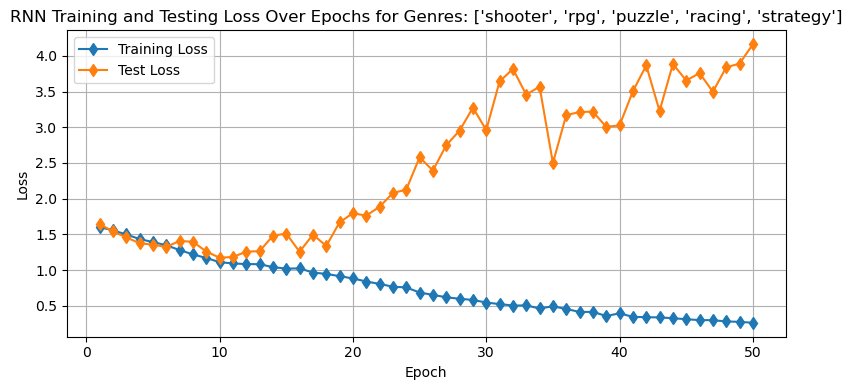

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'RNN Training and Testing Loss Over Epochs for Genres: {genres}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

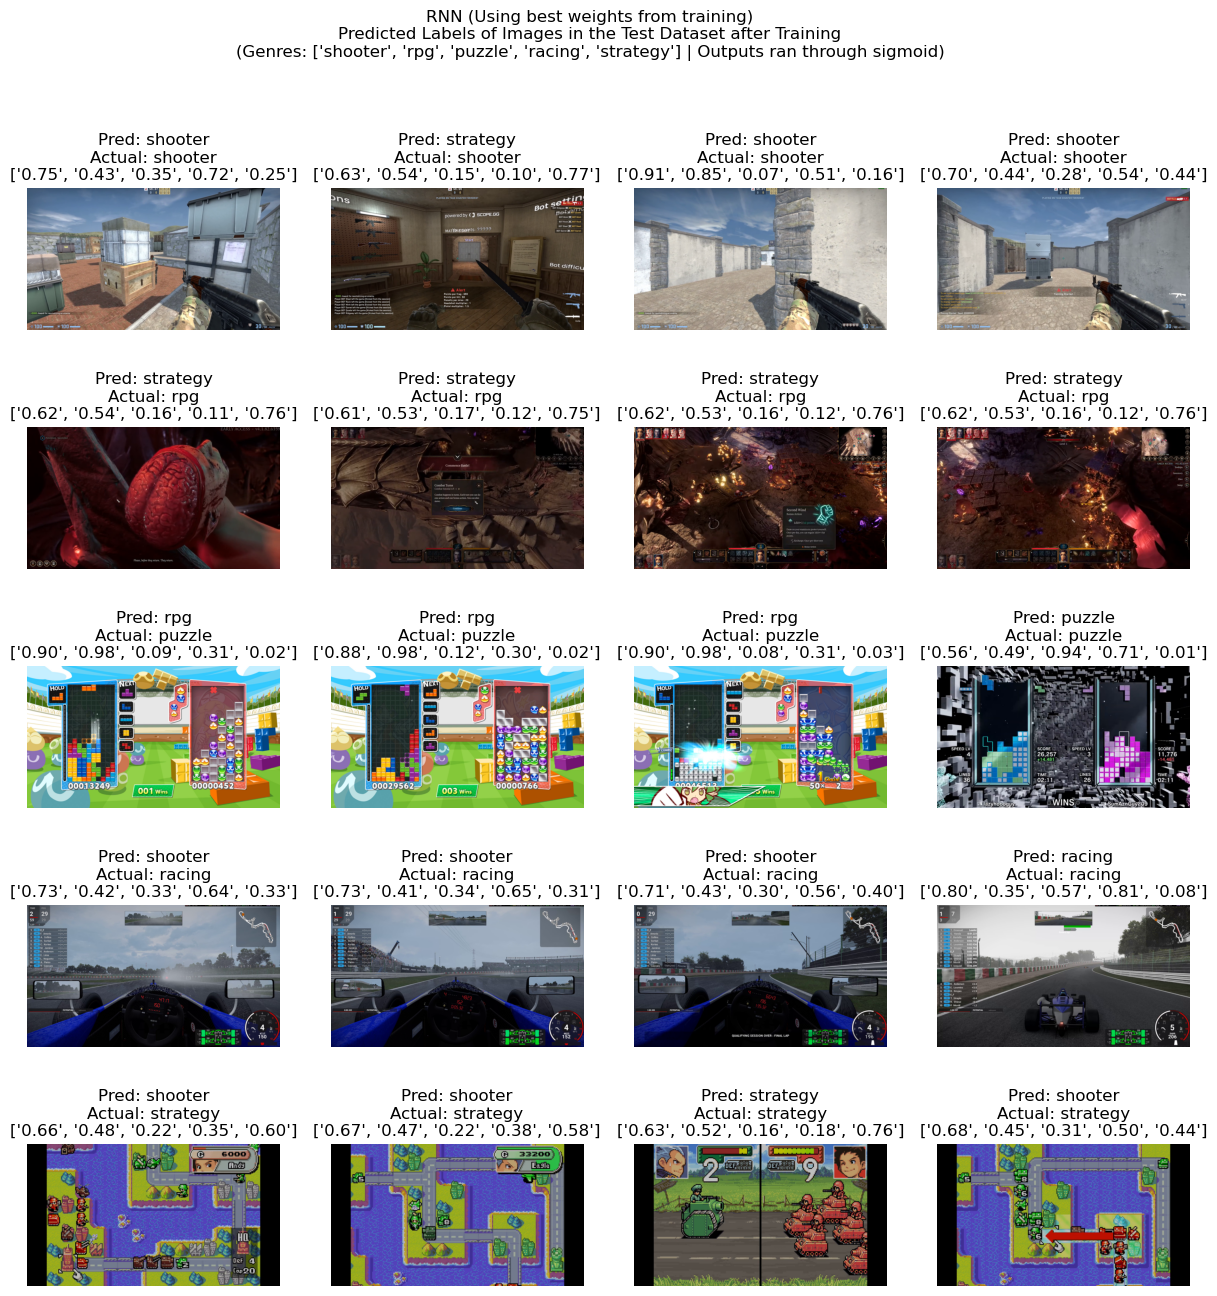

In [30]:
# Set model to evaluation mode and load in the best performing set of weights
model = ClassificationRNN().to(device)
model.eval()
model.load_state_dict(torch.load('best', map_location=torch.device(device), weights_only=True))

ncols = 4

# make a figure object
fig = plt.figure(figsize=(15,len(genres) * 3))
gs = gridspec.GridSpec(5, ncols)

counts = {} # test_data, test_labels
file_count = 0
validation_data, validation_labels, validation_images = generate_sequences(test_images, length, ratio=0.3, skip=True)
sigmoid = nn.Sigmoid()
for i in range(len(validation_data)):
    if validation_labels[i] in counts:
        if counts[validation_labels[i]] >= ncols:
            continue
        counts[validation_labels[i]] += 1
    else:
        file_count = 0
        counts[validation_labels[i]] = 1
    input_tensor = torch.tensor(validation_data[i]).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    predicted_class = genres[predicted.item()]
    # add the image to the plot with the prediction
    ax = fig.add_subplot(gs[validation_labels[i], file_count])
    ax.imshow(Image.open(os.path.join('input_images', 'test', validation_images[i])))
    ax.axis('off')
    probs = ["{:.2f}".format(sigmoid(torch.Tensor([i]))[0]) for i in output.cpu().numpy()[0]]
    ax.set_title(f'Pred: {predicted_class}\nActual: {genres[validation_labels[i]]}\n{probs}')
    file_count += 1

plt.suptitle(f'RNN (Using best weights from training)\nPredicted Labels of Images in the Test Dataset after Training\n(Genres: {genres} | Outputs ran through sigmoid)')
plt.show()